### Import relevant modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.ndimage import gaussian_filter
from scipy import stats
import statsmodels.api as sm
import pylab

from dipy.reconst.dki import DiffusionKurtosisModel
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.viz import window, actor

Denoising code. 

Note: function genpca is a function that allows one to use all different denoising tested in this work. This function was adapted from the denoising procedures in the diffusion in python package (DIPY).

In [2]:
from dipy.denoise.localpca import _pca_classifier
from scipy.linalg import eigh

def _gpca_classifier(L, varest):
    """ Classifies which PCA eigenvalues are related to noise and estimates the
    noise variance

    Parameters
    ----------
    L : array (n,)
        Array containing the PCA eigenvalues in ascending order.
    nvoxels : int
        Number of voxels used to compute L
    varest : float
        Variance prior estimate (if you don't have this you cannot use this method)

    Returns
    -------
    var : float
        Estimation of the noise variance
    ncomps : int
        Number of eigenvalues related to noise

    Notes
    -----
    This is based on the algorithm described in [2]_.
    
    References
    ----------
    .. [2] Henriques et al. PCA denoising 2023
    """
    var = np.mean(L)
    c = L.size - 1
    while var > varest:
        var = np.mean(L[:c])
        c = c - 1
    ncomps = c + 1
    return var, ncomps


def genpca(arr, sigma=None, mask=None, patch_radius=2,
           pca_method='eig', tau_factor=None, return_sigma=False, out_dtype=None):
    r"""General function to perform PCA-based denoising of diffusion datasets.

    Parameters
    ----------
    arr : 4D array
        Array of data to be denoised. The dimensions are (X, Y, Z, N), where N
        are the diffusion gradient directions.
    sigma : float or 3D array (optional)
        Standard deviation of the noise estimated from the data. If no sigma
        is given, this will be estimated based on random matrix theory
        [1]_,[2]_
    mask : 3D boolean array (optional)
        A mask with voxels that are true inside the brain and false outside of
        it. The function denoises within the true part and returns zeros
        outside of those voxels.
    patch_radius : int or 1D array (optional)
        The radius of the local patch to be taken around each voxel (in
        voxels). Default: 2 (denoise in blocks of 5x5x5 voxels).
    pca_method : 'eig' or 'svd' (optional)
        Use either eigenvalue decomposition (eig) or singular value
        decomposition (svd) for principal component analysis. The default
        method is 'eig' which is faster. However, occasionally 'svd' might be
        more accurate.
    tau_factor : float (optional)
        If this variable is not None, thresholding of PCA eigenvalues is done
        by nulling out eigenvalues that are smaller than:

        .. math ::

                \tau = (\tau_{factor} \sigma)^2

        \tau_{factor} can be set to a predefined values (e.g. \tau_{factor} =
        2.3 [3]_). In case that the variable is not defined (i.e. in case that \tau_{factor} is set to None),
        tau_factor is calculated according MP-PCA distribution in case that noise variance
        is not give. If noise variance is given, GPCA algorithm is used.
        Default: None.
    return_sigma : bool (optional)
        If true, the Standard deviation of the noise will be returned.
        Default: False.
    out_dtype : str or dtype (optional)
        The dtype for the output array. Default: output has the same dtype as
        the input.

    Returns
    -------
    denoised_arr : 4D array
        This is the denoised array of the same size as that of the input data,
        clipped to non-negative values

    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    .. [2] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    .. [3] Manjon JV, Coupe P, Concha L, Buades A, Collins DL (2013)
           Diffusion Weighted Image Denoising Using Overcomplete Local
           PCA. PLoS ONE 8(9): e73021.
           https://doi.org/10.1371/journal.pone.0073021
    """
    if mask is None:
        # If mask is not specified, use the whole volume
        mask = np.ones_like(arr, dtype=bool)[..., 0]

    if out_dtype is None:
        out_dtype = arr.dtype

    # We retain float64 precision, iff the input is in this precision:
    if arr.dtype == np.float64:
        calc_dtype = np.float64
    # Otherwise, we'll calculate things in float32 (saving memory)
    else:
        calc_dtype = np.float32

    if not arr.ndim == 4:
        raise ValueError("PCA denoising can only be performed on 4D arrays.",
                         arr.shape)

    if pca_method.lower() == 'svd':
        is_svd = True
    elif pca_method.lower() == 'eig':
        is_svd = False
    else:
        raise ValueError("pca_method should be either 'eig' or 'svd'")

    if isinstance(patch_radius, int):
        patch_radius = np.ones(3, dtype=int) * patch_radius
    if len(patch_radius) != 3:
        raise ValueError("patch_radius should have length 3")
    else:
        patch_radius = np.asarray(patch_radius).astype(int)
    patch_size = 2 * patch_radius + 1

    if np.prod(patch_size) < arr.shape[-1]:
        e_s = "You asked for PCA denoising with a "
        e_s += "patch_radius of {0} ".format(patch_radius)
        e_s += "with total patch size of {0}".format(np.prod(patch_size))
        e_s += "for data with {0} directions. ".format(arr.shape[-1])
        e_s += "This would result in an ill-conditioned PCA matrix. "
        e_s += "Please increase the patch_radius."
        raise ValueError(e_s)

    if isinstance(sigma, np.ndarray):
        #var = sigma ** 2
        if not sigma.shape == arr.shape[:-1]:
            e_s = "You provided a sigma array with a shape"
            e_s += "{0} for data with".format(sigma.shape)
            e_s += "shape {0}. Please provide a sigma array".format(arr.shape)
            e_s += " that matches the spatial dimensions of the data."
            raise ValueError(e_s)
    elif isinstance(sigma, (int, float)):
        sigma = sigma * np.ones(arr.shape[:-1])
        #var = sigma ** 2 * np.ones(arr.shape[:-1])

    dim = arr.shape[-1]
    #if tau_factor is None:
    #    tau_factor = 1 + np.sqrt(dim / np.prod(patch_size))

    theta = np.zeros(arr.shape, dtype=calc_dtype)
    thetax = np.zeros(arr.shape, dtype=calc_dtype)
    ncall = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    thetavar = np.zeros(arr.shape[:-1], dtype=calc_dtype)
    if return_sigma is True:
        out_sigma = np.zeros(arr.shape[:-1], dtype=calc_dtype)

    # loop around and find the 3D patch for each direction at each pixel
    for k in range(patch_radius[2], arr.shape[2] - patch_radius[2]):
        for j in range(patch_radius[1], arr.shape[1] - patch_radius[1]):
            for i in range(patch_radius[0], arr.shape[0] - patch_radius[0]):
                # Shorthand for indexing variables:
                if not mask[i, j, k]:
                    continue
                ix1 = i - patch_radius[0]
                ix2 = i + patch_radius[0] + 1
                jx1 = j - patch_radius[1]
                jx2 = j + patch_radius[1] + 1
                kx1 = k - patch_radius[2]
                kx2 = k + patch_radius[2] + 1

                X = arr[ix1:ix2, jx1:jx2, kx1:kx2].reshape(
                                np.prod(patch_size), dim)
                # compute the mean and normalize
                M = np.mean(X, axis=0)
                # Upcast the dtype for precision in the SVD
                X = X - M

                if is_svd:
                    # PCA using an SVD
                    U, S, Vt = svd(X, *svd_args)[:3]
                    # Items in S are the eigenvalues, but in ascending order
                    # We invert the order (=> descending), square and normalize
                    # \lambda_i = s_i^2 / n
                    d = S[::-1] ** 2 / X.shape[0]
                    # Rows of Vt are eigenvectors, but also in ascending
                    # eigenvalue order:
                    W = Vt[::-1].T

                else:
                    # PCA using an Eigenvalue decomposition
                    C = np.transpose(X).dot(X)
                    C = C / X.shape[0]
                    [d, W] = eigh(C, turbo=True)

                if sigma is None:
                    # Random matrix theory
                    this_var, ncomps = _pca_classifier(d, np.prod(patch_size))
                else:
                    # Predefined variance
                    this_var = sigma[i, j, k] ** 2
                    if tau_factor is None:
                        this_var, ncomps = _gpca_classifier(d, this_var)
                    else:
                        # tau_factor = 1 + np.sqrt(n / m)
                        tau = tau_factor ** 2 * this_var
                        # Update ncomps according to tau_factor
                        ncomps = np.sum(d < tau)

                W[:, :ncomps] = 0

                # This is equations 1 and 2 in Manjon 2013:
                Xest = X.dot(W).dot(W.T) + M
                Xest = Xest.reshape(patch_size[0],
                                    patch_size[1],
                                    patch_size[2], dim)
                # This is equation 3 in Manjon 2013:
                this_theta = 1.0 / (1.0 + dim - ncomps)
                theta[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                thetax[ix1:ix2, jx1:jx2, kx1:kx2] += Xest * this_theta
                ncall[ix1:ix2, jx1:jx2, kx1:kx2] += (dim - ncomps) * this_theta
                thetavar[ix1:ix2, jx1:jx2, kx1:kx2] += this_theta
                
                if return_sigma is True:
                    out_sigma[ix1:ix2, jx1:jx2, kx1:kx2] += np.sqrt(this_var) * this_theta

    denoised_arr = thetax / theta
    denoised_arr.clip(min=0, out=denoised_arr)
    denoised_arr[mask == 0] = 0
    ncall = ncall / thetavar

    if return_sigma is True:
        out_sigma = out_sigma / thetavar
        out_sigma[mask == 0] = 0
        return denoised_arr.astype(out_dtype), out_sigma, ncall

    else:
        return denoised_arr.astype(out_dtype)

## Let's load the data

In [3]:
path = 'D:/Data/CIMEC/'

data, affine = load_nifti(path + 'CIMEC-PRISMA-EXPORT__20220208161351_11_SANDI-AP-mag.nii')
mask, affine = load_nifti(path + 'CIMEC-PRISMA-EXPORT__20220208161351_11_SANDI-AP-mag_brain_mask.nii')

data = data.astype('float64')

bvals, bvecs = read_bvals_bvecs(path + 'CIMEC-PRISMA-EXPORT__20220208161351_11.bval',
                                path + 'CIMEC-PRISMA-EXPORT__20220208161351_11.bvec')
gtab = gradient_table(bvals, bvecs)

print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (110, 110, 63, 167)


Text(0, 0.5, 'b-value')

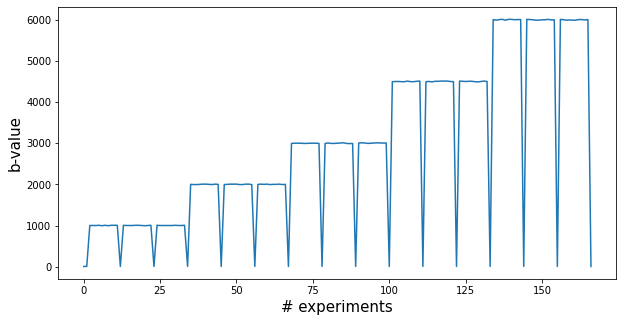

In [4]:
fig = plt.figure(figsize=(10, 5))
plt.plot(gtab.bvals)
plt.xlabel('# experiments', fontsize=15)
plt.ylabel('b-value', fontsize=15)

In [5]:
print(np.sum(gtab.b0s_mask))
print(np.sum(np.logical_and(gtab.bvals>500, gtab.bvals<1500)))

17
30


# Estimate noise STD and SNR

For this dataset, 17 images for b-value=0 were acquired. In this study, we computed the noise variance as the variance of signals acquired at b-value=0 along different repetitions. A pitfall of these noise variance estimates is that they may be corrupted by image artefacts such as motion, cardiac pulsation, and signal drifts. Therefore, to minimize the impact of artefacts, we first compute the noise variance maps using only five b-value=0 image repetitions.

In [6]:
S0s = data[:, :, :, gtab.b0s_mask]
stdS0i = np.std(S0s[:, :, :, :5], axis=-1, ddof=1)
#stdS0a = np.std(S0s, axis=-1, ddof=1)
meanS0 = np.mean(S0s, axis=-1)

Note that we can take the median of sliding windows to remove outliers on noise maps. Bellow, I will compute the effective noise maps used by the algorithms.

In [7]:
def median_filt(sigma, patch_radius=2):
    r"""function to inspect the actual sigma used by denosing algorithms
    if sigma is selected from the median of sliding windowns

    Parameters
    ----------
    arr : 4D array
        Array of data to be denoised. The dimensions are (X, Y, Z, N), where N
        are the diffusion gradient directions.
    sigma : float or 3D array (optional)
        Standard deviation of the noise estimated from the data. If no sigma
        is given, this will be estimated based on random matrix theory
        [1]_,[2]_
    mask : 3D boolean array (optional)
        A mask with voxels that are true inside the brain and false outside of
        it. The function denoises within the true part and returns zeros
        outside of those voxels.
    patch_radius : int or 1D array (optional)
        The radius of the local patch to be taken around each voxel (in
        voxels). Default: 2 (denoise in blocks of 5x5x5 voxels).
    pca_method : 'eig' or 'svd' (optional)
        Use either eigenvalue decomposition (eig) or singular value
        decomposition (svd) for principal component analysis. The default
        method is 'eig' which is faster. However, occasionally 'svd' might be
        more accurate.
    tau_factor : float (optional)
        If this variable is not None, thresholding of PCA eigenvalues is done
        by nulling out eigenvalues that are smaller than:

        .. math ::

                \tau = (\tau_{factor} \sigma)^2

        \tau_{factor} can be set to a predefined values (e.g. \tau_{factor} =
        2.3 [3]_). In case that the variable is not defined (i.e. in case that \tau_{factor} is set to None),
        tau_factor is calculated according MP-PCA distribution in case that noise variance
        is not give. If noise variance is given, GPCA algorithm is used.
        Default: None.
    return_sigma : bool (optional)
        If true, the Standard deviation of the noise will be returned.
        Default: False.
    out_dtype : str or dtype (optional)
        The dtype for the output array. Default: output has the same dtype as
        the input.

    Returns
    -------
    denoised_arr : 4D array
        This is the denoised array of the same size as that of the input data,
        clipped to non-negative values

    References
    ----------
    .. [1] Veraart J, Novikov DS, Christiaens D, Ades-aron B, Sijbers,
           Fieremans E, 2016. Denoising of Diffusion MRI using random matrix
           theory. Neuroimage 142:394-406.
           doi: 10.1016/j.neuroimage.2016.08.016
    .. [2] Veraart J, Fieremans E, Novikov DS. 2016. Diffusion MRI noise
           mapping using random matrix theory. Magnetic Resonance in Medicine.
           doi: 10.1002/mrm.26059.
    .. [3] Manjon JV, Coupe P, Concha L, Buades A, Collins DL (2013)
           Diffusion Weighted Image Denoising Using Overcomplete Local
           PCA. PLoS ONE 8(9): e73021.
           https://doi.org/10.1371/journal.pone.0073021
    """
    
    sigma_final = np.zeros(sigma.shape)
    # loop around and find the 3D patch for each direction at each pixel
    for k in range(patch_radius[2], sigma.shape[2] - patch_radius[2]):
        for j in range(patch_radius[1], sigma.shape[1] - patch_radius[1]):
            for i in range(patch_radius[0], sigma.shape[0] - patch_radius[0]):
                
                ix1 = i - patch_radius[0]
                ix2 = i + patch_radius[0] + 1
                jx1 = j - patch_radius[1]
                jx2 = j + patch_radius[1] + 1
                kx1 = k - patch_radius[2]
                kx2 = k + patch_radius[2] + 1
               
                this_var = np.median(sigma[ix1:ix2, jx1:jx2, kx1:kx2])
                sigma_final[i, j, k] = this_var
                
    return sigma_final

In [8]:
# Size of sliding windown
pr = [4, 4, 1]

stdS0i_m = median_filt(stdS0i, patch_radius=pr)
#stdS0a_m = median_filt(stdS0a, patch_radius=pr)

#gauss_std = 4
#stdgfi = gaussian_filter(stdS0i, sigma=gauss_std)
#stdgfa = gaussian_filter(stdS0a, sigma=gauss_std)

Let's plot the noise maps. 

In [9]:
# to have a relative reference, let's plot the noise maps
# as a reference of the mean value of brain voxels at b=0
flat_mask = mask.flatten()
flat_mS0 = meanS0.flatten()
refval = np.mean(flat_mS0[flat_mask==1])

# select representative axial image
sli = 31

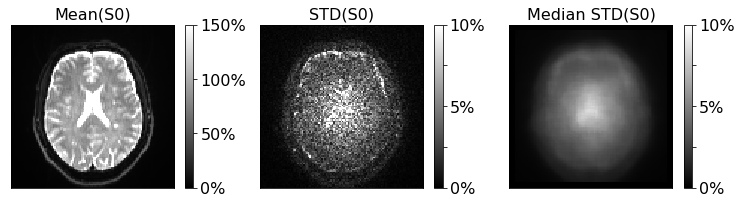

In [10]:
fig1, ax = plt.subplots(1, 3, figsize=(13, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.03, wspace=0.1)
cax0 = ax.flat[0].imshow(meanS0[:, :, sli].T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=150, interpolation='nearest')
ax.flat[0].set_title('Mean(S0)', fontsize=16)


cax1 = ax.flat[1].imshow(stdS0i[:, :, sli].T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=10, interpolation='nearest')
ax.flat[1].set_title('STD(S0)', fontsize=16)


cax2 = ax.flat[2].imshow(stdS0i_m[:, :, sli].T/refval*100,
                  origin='lower', cmap='gray',
                  vmin=0, vmax=10, interpolation='nearest')
ax.flat[2].set_title('Median STD(S0)', fontsize=16)

cbar = fig1.colorbar(cax0, ax=ax.flat[0], ticks=[0, 50, 100, 150])
cbar.ax.set_yticklabels(['0%', '50%', '100%', '150%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax1, ax=ax.flat[1], ticks=[0, 2.5, 5, 7.5, 10])
cbar.ax.set_yticklabels(['0%', '', '5%', '', '10%'])
cbar.ax.tick_params(labelsize=16) 

cbar = fig1.colorbar(cax2, ax=ax.flat[2], ticks=[0, 2.5, 5, 7.5, 10])
cbar.ax.set_yticklabels(['0%', '', '5%', '', '10%'])
cbar.ax.tick_params(labelsize=16) 

# Denoise data

To speed the code let's only denoise a slice.

In [11]:
sel_slice = np.zeros(stdS0i.shape)
sel_slice[:, :, sli] = 1

sel_mask = np.zeros(stdS0i.shape)
sel_mask[:, :, sli] = mask[:, :, sli]

In [12]:
t = time()

den_mp1, sig_mp1, nc_mp1 = genpca(data, mask=sel_slice, patch_radius=pr,
                                  return_sigma=True)

print("Time taken for MP-PCA ", -t + time())

<ipython-input-2-eacf166c48f8>:241: RuntimeWarning: invalid value encountered in true_divide
  denoised_arr = thetax / theta
<ipython-input-2-eacf166c48f8>:244: RuntimeWarning: invalid value encountered in true_divide
  ncall = ncall / thetavar
<ipython-input-2-eacf166c48f8>:247: RuntimeWarning: invalid value encountered in true_divide
  out_sigma = out_sigma / thetavar


Time taken for MP-PCA  225.5462543964386


In [13]:
t = time()

den_gpca, sig_gpca, nc_gpca = genpca(data, mask=sel_slice, patch_radius=pr,
                                     sigma = stdS0i_m, return_sigma=True)

print("Time taken for GPCA ", -t + time())

<ipython-input-2-eacf166c48f8>:241: RuntimeWarning: invalid value encountered in true_divide
  denoised_arr = thetax / theta
<ipython-input-2-eacf166c48f8>:244: RuntimeWarning: invalid value encountered in true_divide
  ncall = ncall / thetavar
<ipython-input-2-eacf166c48f8>:247: RuntimeWarning: invalid value encountered in true_divide
  out_sigma = out_sigma / thetavar


Time taken for GPCA  209.9170000553131


In [14]:
t = time()

m = (2*pr[0] + 1) * (2*pr[1] + 1) * (2*pr[2] + 1)
n = gtab.bvals.size
tau_factor = 1 + np.sqrt(n / m)
den_tpca, sig_tpca, nc_tpca = genpca(data, mask=sel_slice, patch_radius=pr,
                                     sigma = stdS0i_m, tau_factor=tau_factor,
                                     return_sigma=True)

print("Time taken for TPCA ", -t + time())

<ipython-input-2-eacf166c48f8>:241: RuntimeWarning: invalid value encountered in true_divide
  denoised_arr = thetax / theta
<ipython-input-2-eacf166c48f8>:244: RuntimeWarning: invalid value encountered in true_divide
  ncall = ncall / thetavar
<ipython-input-2-eacf166c48f8>:247: RuntimeWarning: invalid value encountered in true_divide
  out_sigma = out_sigma / thetavar


Time taken for TPCA  216.53782987594604


Let's plot number of principal components preserved for each technique. For a better inspection of the number of components preserved on brain regions, we mask this maps.

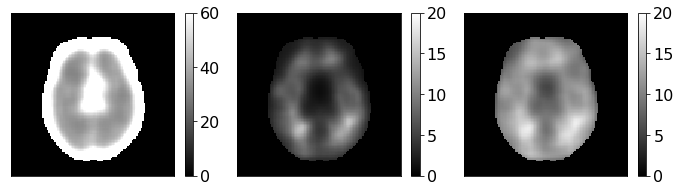

In [15]:
fig1, ax = plt.subplots(1, 3, figsize=(12, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

nc_mp1[mask==0] = 0
nc_gpca[mask==0] = 0
nc_tpca[mask==0] = 0

nc1 = nc_mp1[:, :, sli]
nc2 = nc_gpca[:, :, sli]
nc3 = nc_tpca[:, :, sli]

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
#ax.flat[0].set_title('D) MP-PCA N comps', fontsize=14)
cax = ax.flat[0].imshow(nc1.T, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=60)
cbar = plt.colorbar(cax, ax=ax.flat[0])
cbar.ax.tick_params(labelsize=16) 

#ax.flat[1].set_title('E) H-PCAt N comps', fontsize=14)
cax = ax.flat[1].imshow(nc2.T, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=20)
cbar = plt.colorbar(cax, ax=ax.flat[1])
cbar.ax.tick_params(labelsize=16) 

#ax.flat[2].set_title('F) H-PCAv N comps', fontsize=14)
cax = ax.flat[2].imshow(nc3.T, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=20)
cbar = plt.colorbar(cax, ax=ax.flat[2])
cbar.ax.tick_params(labelsize=16) 

In [16]:
gra1 = 25  # pick out a volume for b-value=1
gra2 = 47  # pick out a volume for b-value=2
gra3 = 74  # pick out a volume for b-value=3
gra4 = 125  # pick out a volume for b-value=4.5
gra6 = 157  # pick out a volume for b-value=6

# selected volumes have diffusion direction near
# v=[1, 0, 0]

gra = [gra2, gra3, gra4, gra6]
print(gtab.bvals[gra])
print(gtab.bvecs[gra])

[2000. 3000. 4500. 6000.]
[[ 0.973992   0.0219278  0.225518 ]
 [ 0.988217   0.0941363 -0.120686 ]
 [-0.984443  -0.173386  -0.0284332]
 [ 0.971037  -0.166647   0.171222 ]]


In [17]:
di = data[:, :, sli, gra[0]]
Data_raw = di.T
for vi in gra[1:]:
    di = data[:, :, sli, vi]
    Data_raw = np.concatenate((Data_raw, di.T), axis=1)
    
di = den_mp1[:, :, sli, gra[0]]
Data_mp = di.T
for vi in gra[1:]:
    di = den_mp1[:, :, sli, vi]
    Data_mp = np.concatenate((Data_mp, di.T), axis=1)
    
di = den_gpca[:, :, sli, gra[0]]
Data_gp = di.T
for vi in gra[1:]:
    di = den_gpca[:, :, sli, vi]
    Data_gp = np.concatenate((Data_gp, di.T), axis=1)

di = den_tpca[:, :, sli, gra[0]]
Data_tp = di.T
for vi in gra[1:]:
    di = den_tpca[:, :, sli, vi]
    Data_tp = np.concatenate((Data_tp, di.T), axis=1)

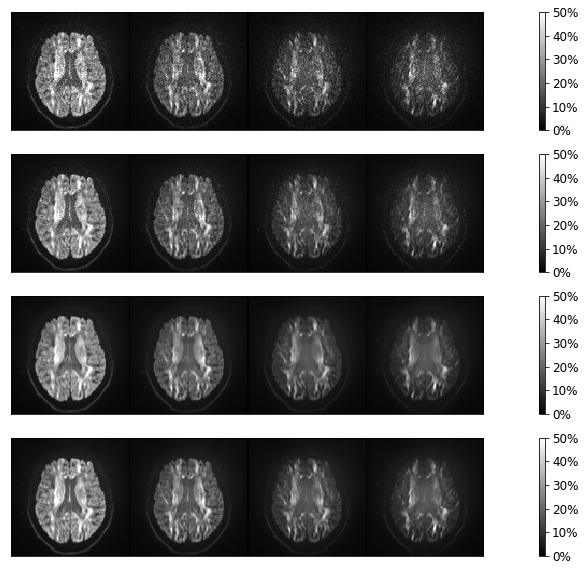

In [18]:
fig1, ax = plt.subplots(4, 1, figsize=(20, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.2, wspace=0.01)
cax = ax.flat[0].imshow(Data_raw/refval*100, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=50)
cbar = plt.colorbar(cax, ax=ax.flat[0], ticks=[0, 10, 20, 30, 40, 50])
cbar.ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
cbar.ax.tick_params(labelsize=12) 

cax = ax.flat[1].imshow(Data_mp/refval*100, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=50)
cbar = plt.colorbar(cax, ax=ax.flat[1], ticks=[0, 10, 20, 30, 40, 50])
cbar.ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
cbar.ax.tick_params(labelsize=12) 

cax = ax.flat[2].imshow(Data_gp/refval*100, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=50)
cbar = plt.colorbar(cax, ax=ax.flat[2], ticks=[0, 10, 20, 30, 40, 50])
cbar.ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
cbar.ax.tick_params(labelsize=12)

cax = ax.flat[3].imshow(Data_tp/refval*100, cmap='gray', interpolation='none',
                        origin='lower', vmin=0, vmax=50)
cbar = plt.colorbar(cax, ax=ax.flat[3], ticks=[0, 10, 20, 30, 40, 50])
cbar.ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
cbar.ax.tick_params(labelsize=12)

Plot residuals

[Text(1, -16, '-16%'),
 Text(1, -8, '-8%'),
 Text(1, 0, '0%'),
 Text(1, 8, '8%'),
 Text(1, 16, '16%')]

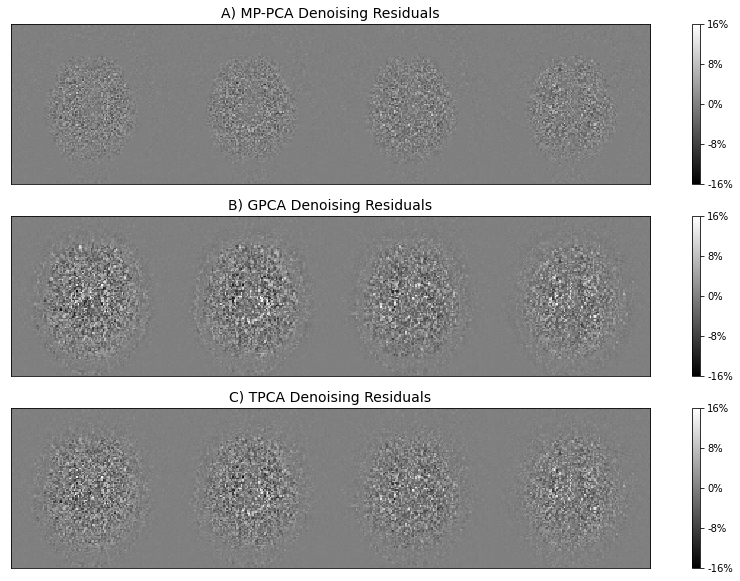

In [19]:
fig1, ax = plt.subplots(3, 1, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.2, wspace=0.2)

cax = ax.flat[0].imshow((Data_raw-Data_mp)/refval*100, cmap='gray', interpolation='none',
                        origin='lower', vmin=-16, vmax=16)
ax.flat[0].set_title('A) MP-PCA Denoising Residuals', fontsize=14)
cbar = plt.colorbar(cax, ax=ax.flat[0], ticks=[-16, -8, 0, 8, 16])
cbar.ax.set_yticklabels(['-16%', '-8%', '0%', '8%', '16%'])

cax = ax.flat[1].imshow((Data_raw-Data_gp)/refval*100, cmap='gray', interpolation='none',
                        origin='lower', vmin=-16, vmax=16)
ax.flat[1].set_title('B) GPCA Denoising Residuals', fontsize=14)
cbar = plt.colorbar(cax, ax=ax.flat[1], ticks=[-16, -8, 0, 8, 16])
cbar.ax.set_yticklabels(['-16%', '-8%', '0%', '8%', '16%'])

cax = ax.flat[2].imshow((Data_raw-Data_tp)/refval*100, cmap='gray', interpolation='none',
                        origin='lower', vmin=-16, vmax=16)
ax.flat[2].set_title('C) TPCA Denoising Residuals', fontsize=14)
cbar = plt.colorbar(cax, ax=ax.flat[2], ticks=[-16, -8, 0, 8, 16])
cbar.ax.set_yticklabels(['-16%', '-8%', '0%', '8%', '16%'])

# DKI fit

In [20]:
# select data for b-values up to 3000 s/mm2
bvals_s = bvals[bvals<3500]
bvecs_s = bvecs[bvals<3500, :]

big_delta = 0.0391  # seconds
small_delta = 0.02634  # seconds
gtab_s = gradient_table(bvals_s, bvecs_s, big_delta=big_delta,
                        small_delta=small_delta)
data_s = data[:, :, :, bvals<3500]
den_mp_s = den_mp1[:, :, :, bvals<3500]
den_gp_s = den_gpca[:, :, :, bvals<3500]
den_tp_s = den_tpca[:, :, :, bvals<3500]

In [21]:
dkim = DiffusionKurtosisModel(gtab_s)
dki_ra = dkim.fit(data_s, mask=sel_mask)
dki_mp = dkim.fit(den_mp_s, mask=sel_mask)
dki_gp = dkim.fit(den_gp_s, mask=sel_mask)
dki_tp = dkim.fit(den_tp_s, mask=sel_mask)

In [22]:
# FA
FA = dki_ra.fa
FA_mp = dki_mp.fa
FA_gp = dki_gp.fa
FA_tp = dki_tp.fa

# MD
MD = dki_ra.md
MD_mp = dki_mp.md
MD_gp = dki_gp.md
MD_tp = dki_tp.md

# AD
AD = dki_ra.ad
AD_mp = dki_mp.ad
AD_gp = dki_gp.ad
AD_tp = dki_tp.ad

# AD
RD = dki_ra.rd
RD_mp = dki_mp.rd
RD_gp = dki_gp.rd
RD_tp = dki_tp.rd

# MK
MK = dki_ra.mk(0, 10)
MK_mp = dki_mp.mk(0, 10)
MK_gp = dki_gp.mk(0, 10)
MK_tp = dki_tp.mk(0, 10)

# AK
AK = dki_ra.ak(0, 10)
AK_mp = dki_mp.ak(0, 10)
AK_gp = dki_gp.ak(0, 10)
AK_tp = dki_tp.ak(0, 10)

# RK
RK = dki_ra.rk(0, 10)
RK_mp = dki_mp.rk(0, 10)
RK_gp = dki_gp.rk(0, 10)
RK_tp = dki_tp.rk(0, 10)

### Plot DKI results

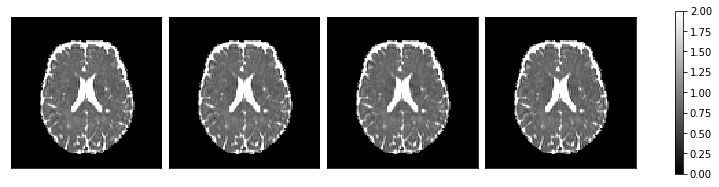

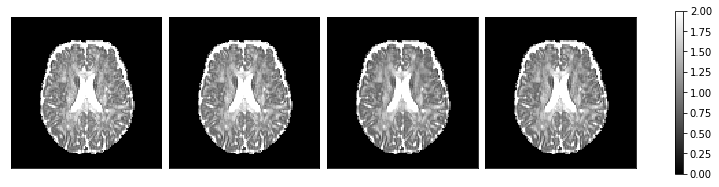

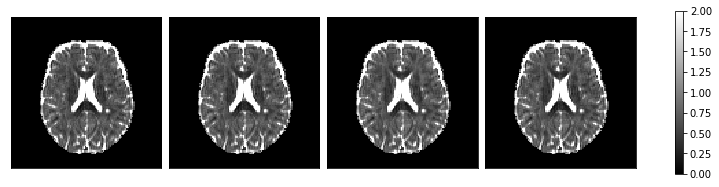

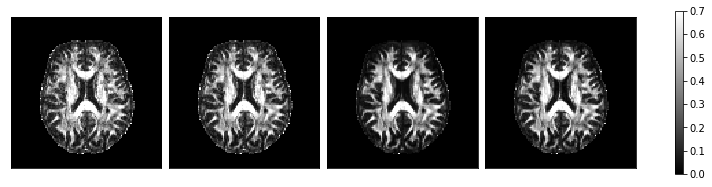

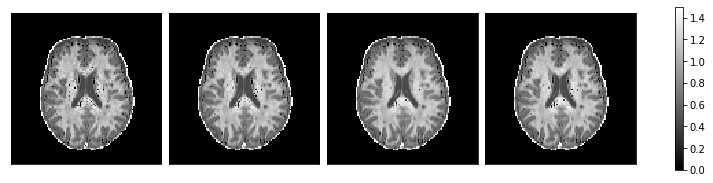

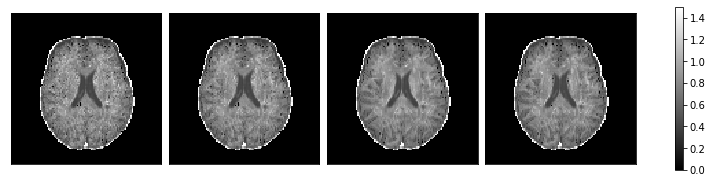

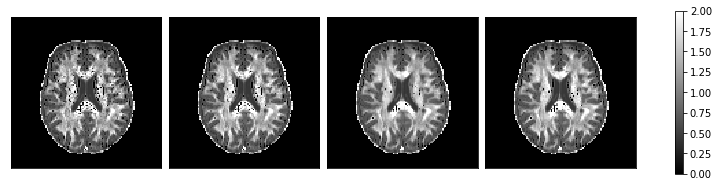

In [23]:
########################## MD #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MD[:, :, sli]*1000
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

Met =  MD_mp[:, :, sli]*1000
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

Met =  MD_gp[:, :, sli]*1000
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')

Met =  MD_tp[:, :, sli]*1000
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='none',
                         vmin=0, vmax=2, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## AD #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  AD[:, :, sli]*1000
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  AD_mp[:, :, sli]*1000
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  AD_gp[:, :, sli]*1000
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  AD_tp[:, :, sli]*1000
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## RD #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  RD[:, :, sli]*1000
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RD_mp[:, :, sli]*1000
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RD_gp[:, :, sli]*1000
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RD_tp[:, :, sli]*1000
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  FA[:, :, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_mp[:, :, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_gp[:, :, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_tp[:, :, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## MK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MK[:, :, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_mp[:, :, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_gp[:, :, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_tp[:, :, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## AK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  AK[:, :, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_mp[:, :, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_gp[:, :, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_tp[:, :, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## RK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  RK[:, :, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_mp[:, :, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_gp[:, :, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_tp[:, :, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

Plot DKI zoom

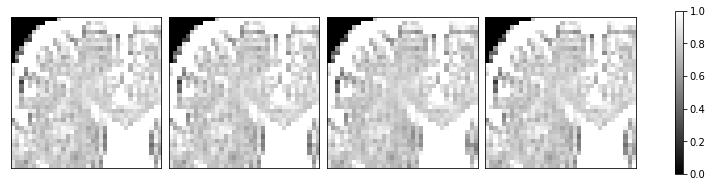

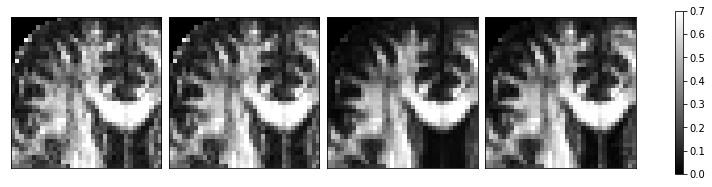

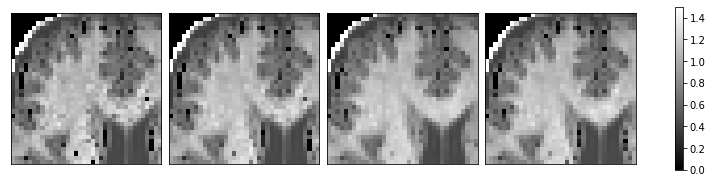

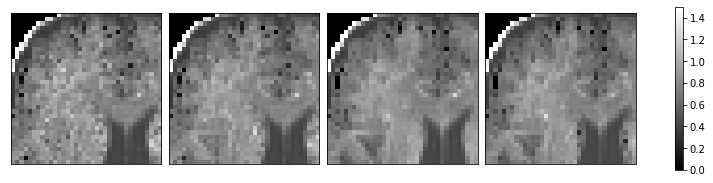

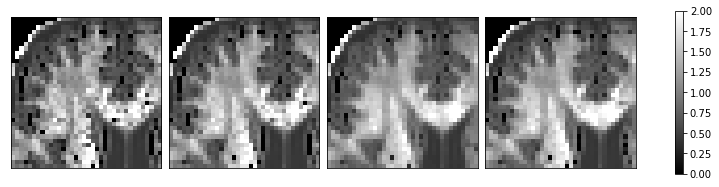

In [24]:
xiii = 27
xfff = 27+36
yiii = 55
yfff = 55+36

########################## MD #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MD[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_mp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_gp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_tp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  FA[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## MK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## AK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  AK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## RK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  RK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

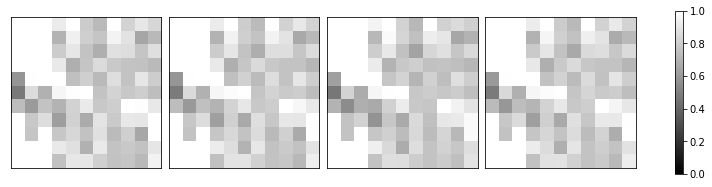

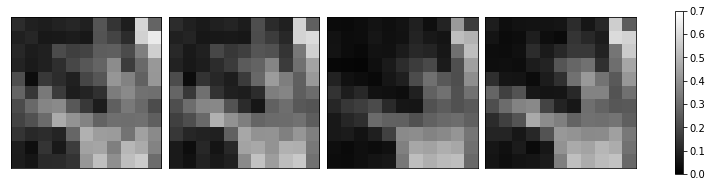

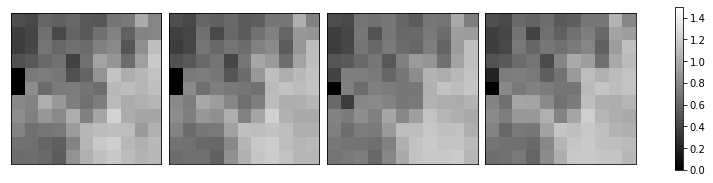

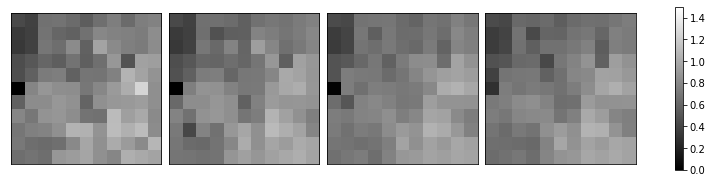

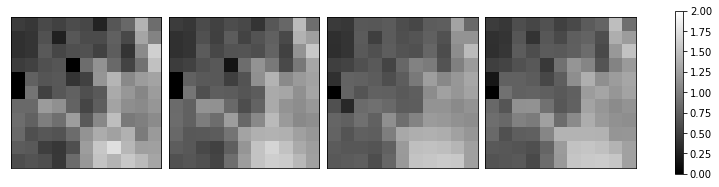

In [25]:
xiii = 30
xfff = 30+11
yiii = 72
yfff = 72+11

########################## MD #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MD[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_mp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_gp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_tp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  FA[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## MK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## AK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  AK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## RK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  RK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

# Check residuals

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


Text(0.5, 0, 'r')

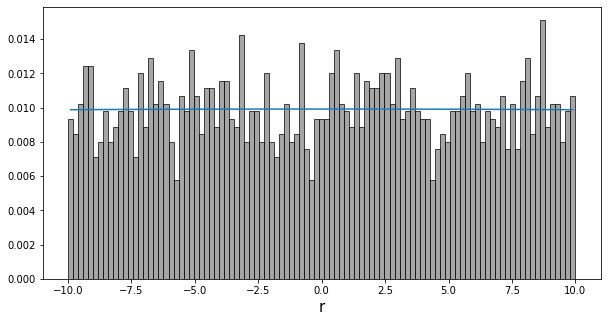

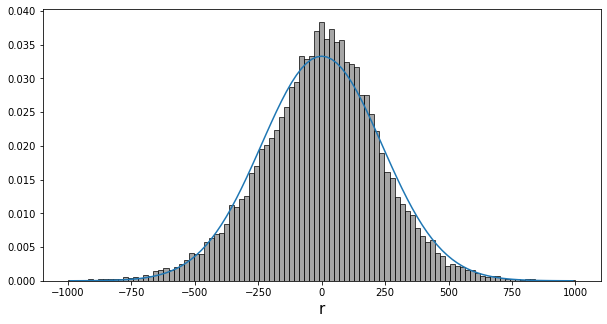

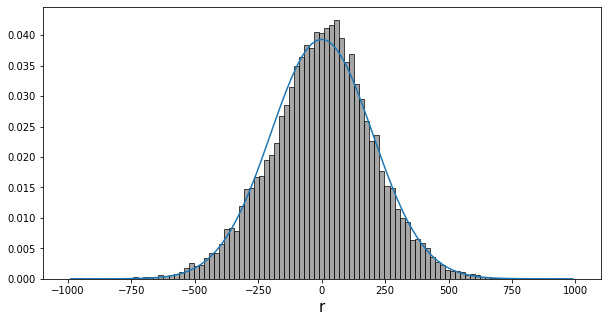

In [26]:
roi = np.zeros(mask.shape)
roi[xiii:xfff, yiii:yfff, sli] = 1

Rmp1_all = den_mp1[:, :, :, :] - data[:, :, :, :]
Rht1_all = den_tpca[:, :, :, :] - data[:, :, :, :]
Rhv1_all = den_gpca[:, :, :, :] - data[:, :, :, :]

Rmp1 = Rmp1_all[:, :, :, 0]
Rht1 = Rht1_all[:, :, :, 0]
Rhv1 = Rhv1_all[:, :, :, 0]

Rmp1_vec = Rmp1[roi==1]
Rht1_vec = Rht1[roi==1]
Rhv1_vec = Rhv1[roi==1]

for vi in range(1, gtab.bvals.size):
    Rmp1 = Rmp1_all[:, :, :, vi]
    Rht1 = Rht1_all[:, :, :, vi]
    Rhv1 = Rhv1_all[:, :, :, vi]
    Rmp1_vec = np.append(Rmp1_vec, Rmp1[roi==1])
    Rht1_vec = np.append(Rht1_vec, Rht1[roi==1])
    Rhv1_vec = np.append(Rhv1_vec, Rhv1[roi==1])
    print(vi)

#pmp1 = np.percentile(np.abs(Rmp1_vec), 95)
#pht1 = np.percentile(np.abs(Rht1_vec), 95)
#phv1 = np.percentile(np.abs(Rhv1_vec), 95)

#Rmp1_final = Rmp1_vec[np.logical_and(Rmp1_vec<pmp1, Rmp1_vec>-pmp1)] 
#Rht1_final = Rht1_vec[np.logical_and(Rht1_vec<pht1, Rht1_vec>-pht1)] 
#Rhv1_final = Rhv1_vec[np.logical_and(Rhv1_vec<phv1, Rhv1_vec>-phv1)] 

Rmp1_final = Rmp1_vec
Rht1_final = Rht1_vec
Rhv1_final = Rhv1_vec

sffmp1 = np.std(Rmp1_final)
sffht1 = np.std(Rht1_final)
sffhv1 = np.std(Rhv1_final)

Rv_mp1 = (Rmp1_final)
Rv_ht1 = (Rht1_final)
Rv_hv1 = (Rhv1_final)

rpos = 1000
rneg = -1000
rpos0 = 10
rneg0 = -10
nb = 101

x = np.linspace(rneg, rpos, num=nb)
x0 = np.linspace(rneg0, rpos0, num=nb)

# Reference 
prefmp1 = np.exp(-1/2 * (x0/sffmp1)**2)
prefmp1 = prefmp1 / np.sum(prefmp1)

prefht1 = np.exp(-1/2 * (x/sffht1)**2)
prefht1 = prefht1 / np.sum(prefht1)

prefhv1 = np.exp(-1/2 * (x/sffhv1)**2)
prefhv1 = prefhv1 / np.sum(prefhv1)

# Bins
beig0, ed0 = np.histogram(Rv_mp1, bins = nb, range=(rneg0, rpos0))
beig_mp1 = beig0 / np.sum(beig0)

beig, ed = np.histogram(Rv_ht1, bins = nb, range=(rneg, rpos))
beig_ht1 = beig / np.sum(beig)

beig, ed = np.histogram(Rv_hv1, bins = nb, range=(rneg, rpos))
beig_hv1 = beig / np.sum(beig)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed0[:-1]+(rpos0-rneg0)/(2*nb), beig_mp1, width = (rpos0-rneg0)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed0[:-1]+(rpos0-rneg0)/(2*nb), prefmp1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_hv1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefhv1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_ht1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefht1)
plt.xlabel('r', fontsize=15)

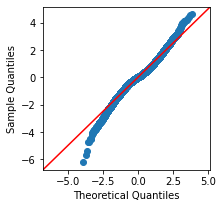

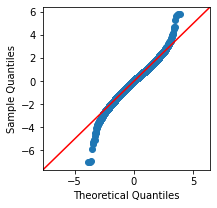

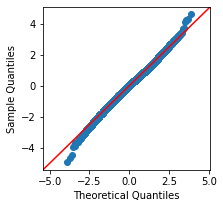

In [27]:
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(3, 3))
    sm.qqplot(Rv_mp1, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rv_hv1, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rv_ht1, line='45', fit=True)
    pylab.show()

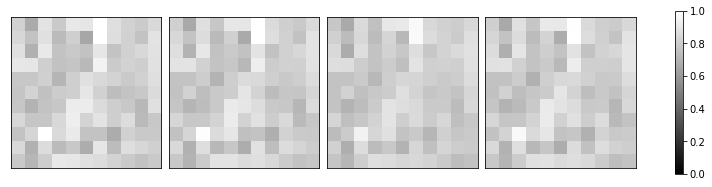

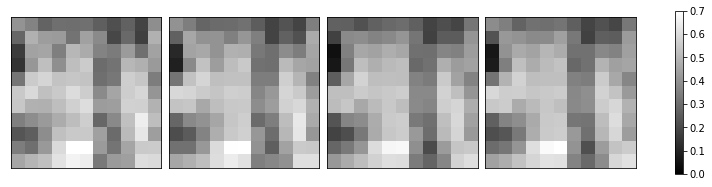

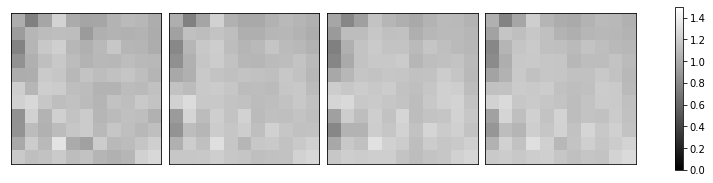

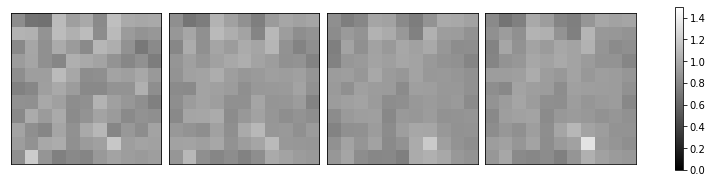

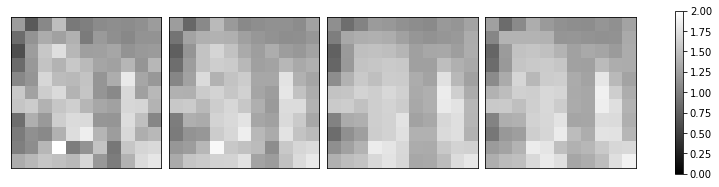

In [28]:
xiii = 34
xfff = 34+11
yiii = 65
yfff = 65+11

########################## MD #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MD[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_mp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_gp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')

Met =  MD_tp[xiii:xfff, yiii:yfff, sli]*1000
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## FA #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  FA[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')

Met =  FA_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=0.7, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## MK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  MK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  MK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## AK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  AK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')

Met =  AK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=1.5, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

########################## RK #####################################

fig2, ax = plt.subplots(1, 4, figsize=(14, 3),
                        subplot_kw={'xticks': [], 'yticks': []})
fig2.subplots_adjust(hspace=0.01, wspace=0.05)

Met =  RK[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[0].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_mp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[1].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_gp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[2].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')

Met =  RK_tp[xiii:xfff, yiii:yfff, sli]
immd = ax.flat[3].imshow(Met.T, cmap='gray', interpolation='nearest',
                         vmin=0, vmax=2, origin='lower')
fig2.colorbar(immd, ax=ax.flat[:])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


Text(0.5, 0, 'r')

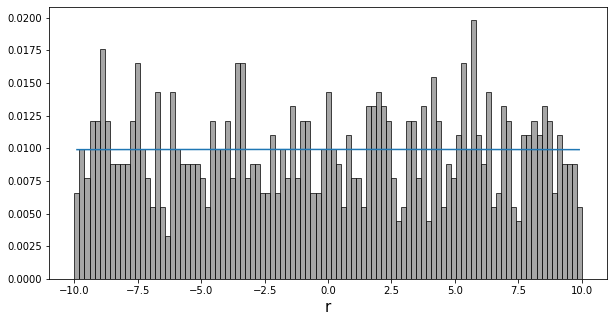

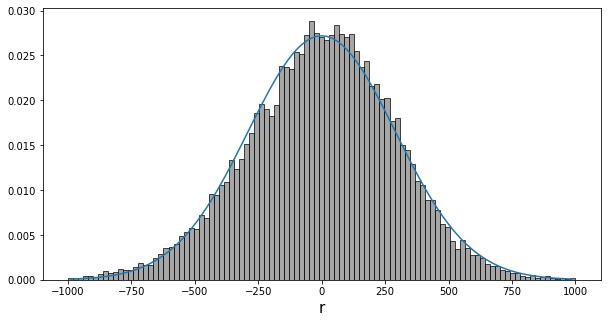

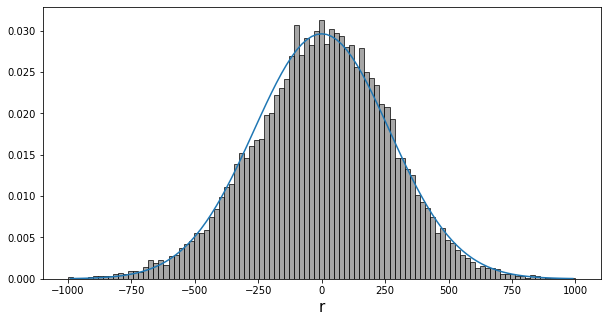

In [29]:
roi = np.zeros(mask.shape)
roi[xiii:xfff, yiii:yfff, sli] = 1

Rmp1_all = den_mp1[:, :, :, :] - data[:, :, :, :]
Rht1_all = den_tpca[:, :, :, :] - data[:, :, :, :]
Rhv1_all = den_gpca[:, :, :, :] - data[:, :, :, :]

Rmp1 = Rmp1_all[:, :, :, 0]
Rht1 = Rht1_all[:, :, :, 0]
Rhv1 = Rhv1_all[:, :, :, 0]

Rmp1_vec = Rmp1[roi==1]
Rht1_vec = Rht1[roi==1]
Rhv1_vec = Rhv1[roi==1]

for vi in range(1, gtab.bvals.size):
    Rmp1 = Rmp1_all[:, :, :, vi]
    Rht1 = Rht1_all[:, :, :, vi]
    Rhv1 = Rhv1_all[:, :, :, vi]
    Rmp1_vec = np.append(Rmp1_vec, Rmp1[roi==1])
    Rht1_vec = np.append(Rht1_vec, Rht1[roi==1])
    Rhv1_vec = np.append(Rhv1_vec, Rhv1[roi==1])
    print(vi)

#pmp1 = np.percentile(np.abs(Rmp1_vec), 95)
#pht1 = np.percentile(np.abs(Rht1_vec), 95)
#phv1 = np.percentile(np.abs(Rhv1_vec), 95)

#Rmp1_final = Rmp1_vec[np.logical_and(Rmp1_vec<pmp1, Rmp1_vec>-pmp1)] 
#Rht1_final = Rht1_vec[np.logical_and(Rht1_vec<pht1, Rht1_vec>-pht1)] 
#Rhv1_final = Rhv1_vec[np.logical_and(Rhv1_vec<phv1, Rhv1_vec>-phv1)] 

Rmp1_final = Rmp1_vec
Rht1_final = Rht1_vec
Rhv1_final = Rhv1_vec

sffmp1 = np.std(Rmp1_final)
sffht1 = np.std(Rht1_final)
sffhv1 = np.std(Rhv1_final)

Rv_mp1 = (Rmp1_final)
Rv_ht1 = (Rht1_final)
Rv_hv1 = (Rhv1_final)

rpos = 1000
rneg = -1000
rpos0 = 10
rneg0 = -10
nb = 101

x = np.linspace(rneg, rpos, num=nb)
x0 = np.linspace(rneg0, rpos0, num=nb)

# Reference 
prefmp1 = np.exp(-1/2 * (x0/sffmp1)**2)
prefmp1 = prefmp1 / np.sum(prefmp1)

prefht1 = np.exp(-1/2 * (x/sffht1)**2)
prefht1 = prefht1 / np.sum(prefht1)

prefhv1 = np.exp(-1/2 * (x/sffhv1)**2)
prefhv1 = prefhv1 / np.sum(prefhv1)

# Bins
beig0, ed0 = np.histogram(Rv_mp1, bins = nb, range=(rneg0, rpos0))
beig_mp1 = beig0 / np.sum(beig0)

beig, ed = np.histogram(Rv_ht1, bins = nb, range=(rneg, rpos))
beig_ht1 = beig / np.sum(beig)

beig, ed = np.histogram(Rv_hv1, bins = nb, range=(rneg, rpos))
beig_hv1 = beig / np.sum(beig)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed0[:-1]+(rpos0-rneg0)/(2*nb), beig_mp1, width = (rpos0-rneg0)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed0[:-1]+(rpos0-rneg0)/(2*nb), prefmp1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_hv1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefhv1)
plt.xlabel('r', fontsize=15)

fig = plt.figure(figsize=(10, 5))
plt.bar(ed[:-1]+(rpos-rneg)/(2*nb), beig_ht1, width = (rpos-rneg)/nb, color='grey', alpha=0.7, edgecolor='black', label='measured dist.')
plt.plot(ed[:-1]+(rpos-rneg)/(2*nb), prefht1)
plt.xlabel('r', fontsize=15)

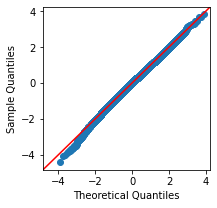

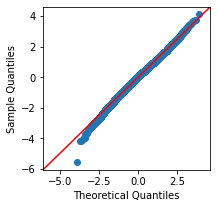

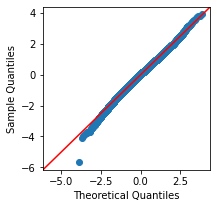

In [30]:
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(3, 3))
    sm.qqplot(Rv_mp1, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rv_hv1, line='45', fit=True)
    pylab.show()
    sm.qqplot(Rv_ht1, line='45', fit=True)
    pylab.show()